In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.switch_backend('Agg') # 不弹窗口 直接后台生成图片
import matplotlib
# matplotlib.use('Agg')

%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = (10, 6)

加载数据集

In [2]:
file_paths = {
    'Sydney': 'datasets/Sydney_Air_Quality.csv',
    'Cairo': 'datasets/Cairo_Air_Quality.csv',
    'Brasilia': 'datasets/Brasilia_Air_Quality.csv',
    'London': 'datasets/London_Air_Quality.csv',
    'General': 'datasets/Air_Quality.csv',
    'Dubai': 'datasets/Dubai_Air_Quality.csv',
    'New York': 'datasets/New_York_Air_Quality.csv'
}

In [3]:
dataframes = []
for city, path in file_paths.items():
    try:
        df = pd.read_csv(path,encoding='ascii')
        if 'Unnamed: 0' in df.columns:
            df.drop('Unnamed: 0', axis=1,inplace=True) # 这是因为导入时候会自动把索引作为新的一列，这样做就是删除没有用的这一列
        dataframes.append(df)
    except Exception as e:
        print(f"Error loading {city} data from {path}: {e}")

df = pd.concat(dataframes, ignore_index=True) # 纵向拼接，然后重新索引，就是新的列表还是从0开始编号
print('Data loaded successfully. Combined shape:', df.shape)


Data loaded successfully. Combined shape: (105120, 9)


In [4]:
try:
    df['Date'] = pd.to_datetime(df['Date'])
except Exception as e:
    print(f"Error converting 'Date' column to datetime: {e}")
# 将日期变为常见的日期格式，然后提取出年、月、日、小时等特征，以及错误

In [5]:
missing_values = df.isnull().sum() # 计算每一列的缺失值数量
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Date     0
City     0
CO       0
NO2      0
SO2      0
O3       0
PM2.5    0
PM10     0
AQI      0
dtype: int64


In [6]:
df.dropna(inplace=True)
# 删除包含缺失值的行， inplace=True表示在原数据上进行修改


In [7]:
df.reset_index(drop=True, inplace=True) # 重置索引，drop=True表示不保留旧索引，inplace=True表示在原数据上进行修改
print("Data shape after cleaning:", df.shape)

Data shape after cleaning: (105120, 9)


In [8]:
# Exploratory Data Analysis

# Display first few rows of the dataframe
print('Preview of the data:')
print(df.head())

# General information about data types and non-null values
print('\nData Info:')
print(df.info())

# Summary statistics for numeric columns
print('\nSummary statistics:')
print(df.describe())

Preview of the data:
                       Date    City    CO   NO2   SO2    O3  PM2.5  PM10  \
0 2023-01-01 00:00:00+00:00  Sydney  62.0  6.00  3.65  41.0    9.2  16.5   
1 2023-01-01 01:00:00+00:00  Sydney  62.0  5.25  3.45  45.0    9.1  16.5   
2 2023-01-01 02:00:00+00:00  Sydney  61.0  4.15  3.20  50.0    8.8  15.9   
3 2023-01-01 03:00:00+00:00  Sydney  61.0  3.20  2.90  55.0    8.8  16.1   
4 2023-01-01 04:00:00+00:00  Sydney  62.0  3.15  2.80  54.0    8.7  16.0   

         AQI  
0  23.583336  
1  23.466667  
2  23.325003  
3  23.150002  
4  22.958332  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   Date    105120 non-null  datetime64[ns, UTC]
 1   City    105120 non-null  object             
 2   CO      105120 non-null  float64            
 3   NO2     105120 non-null  float64            
 4   SO2  

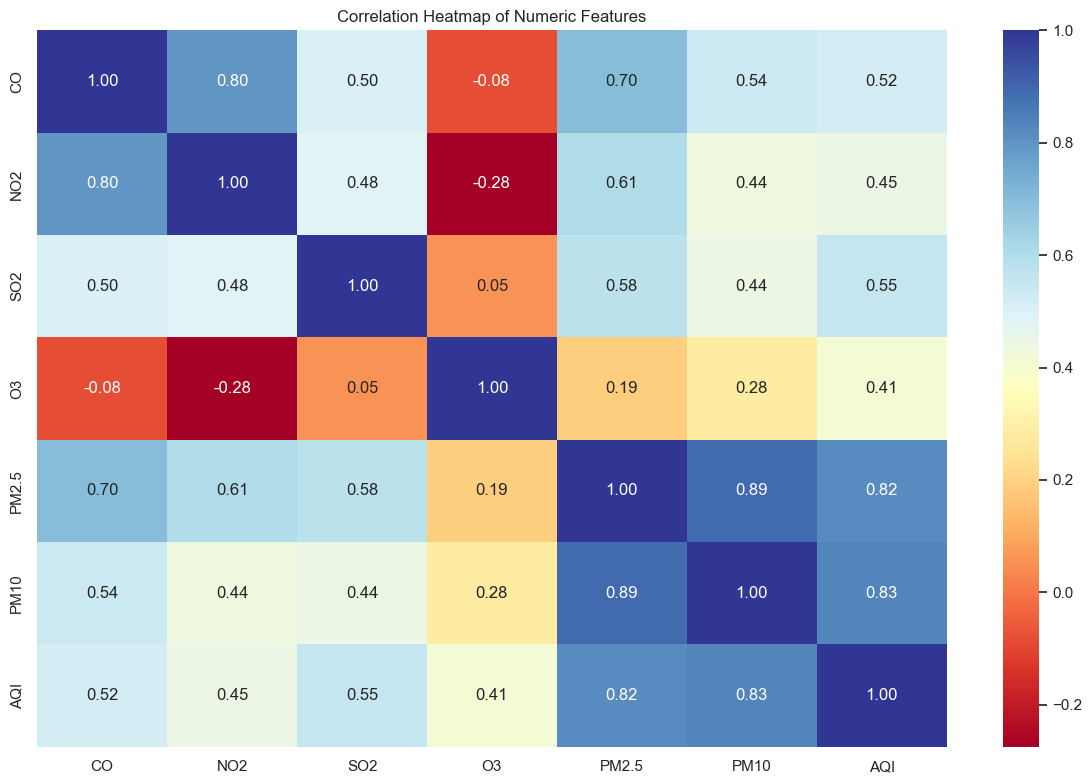

In [ ]:
numeric_df = df.select_dtypes(include=[np.number]) # 从原始数据筛选出数值类型的数据
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 8))
    corr = numeric_df.corr() # 计算特征数值之间的相关性
    sns.heatmap(corr,  # 相关系数矩阵
                annot=True,  # 在每个格子中显示具体的数值
                cmap='RdYlBu', # 正相关为红色，负相关为蓝色 RdYlBu 是一种颜色映射方案,红黄蓝渐变
                fmt='.2f') # 保留两位小数
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to plot a correlation heatmap.")

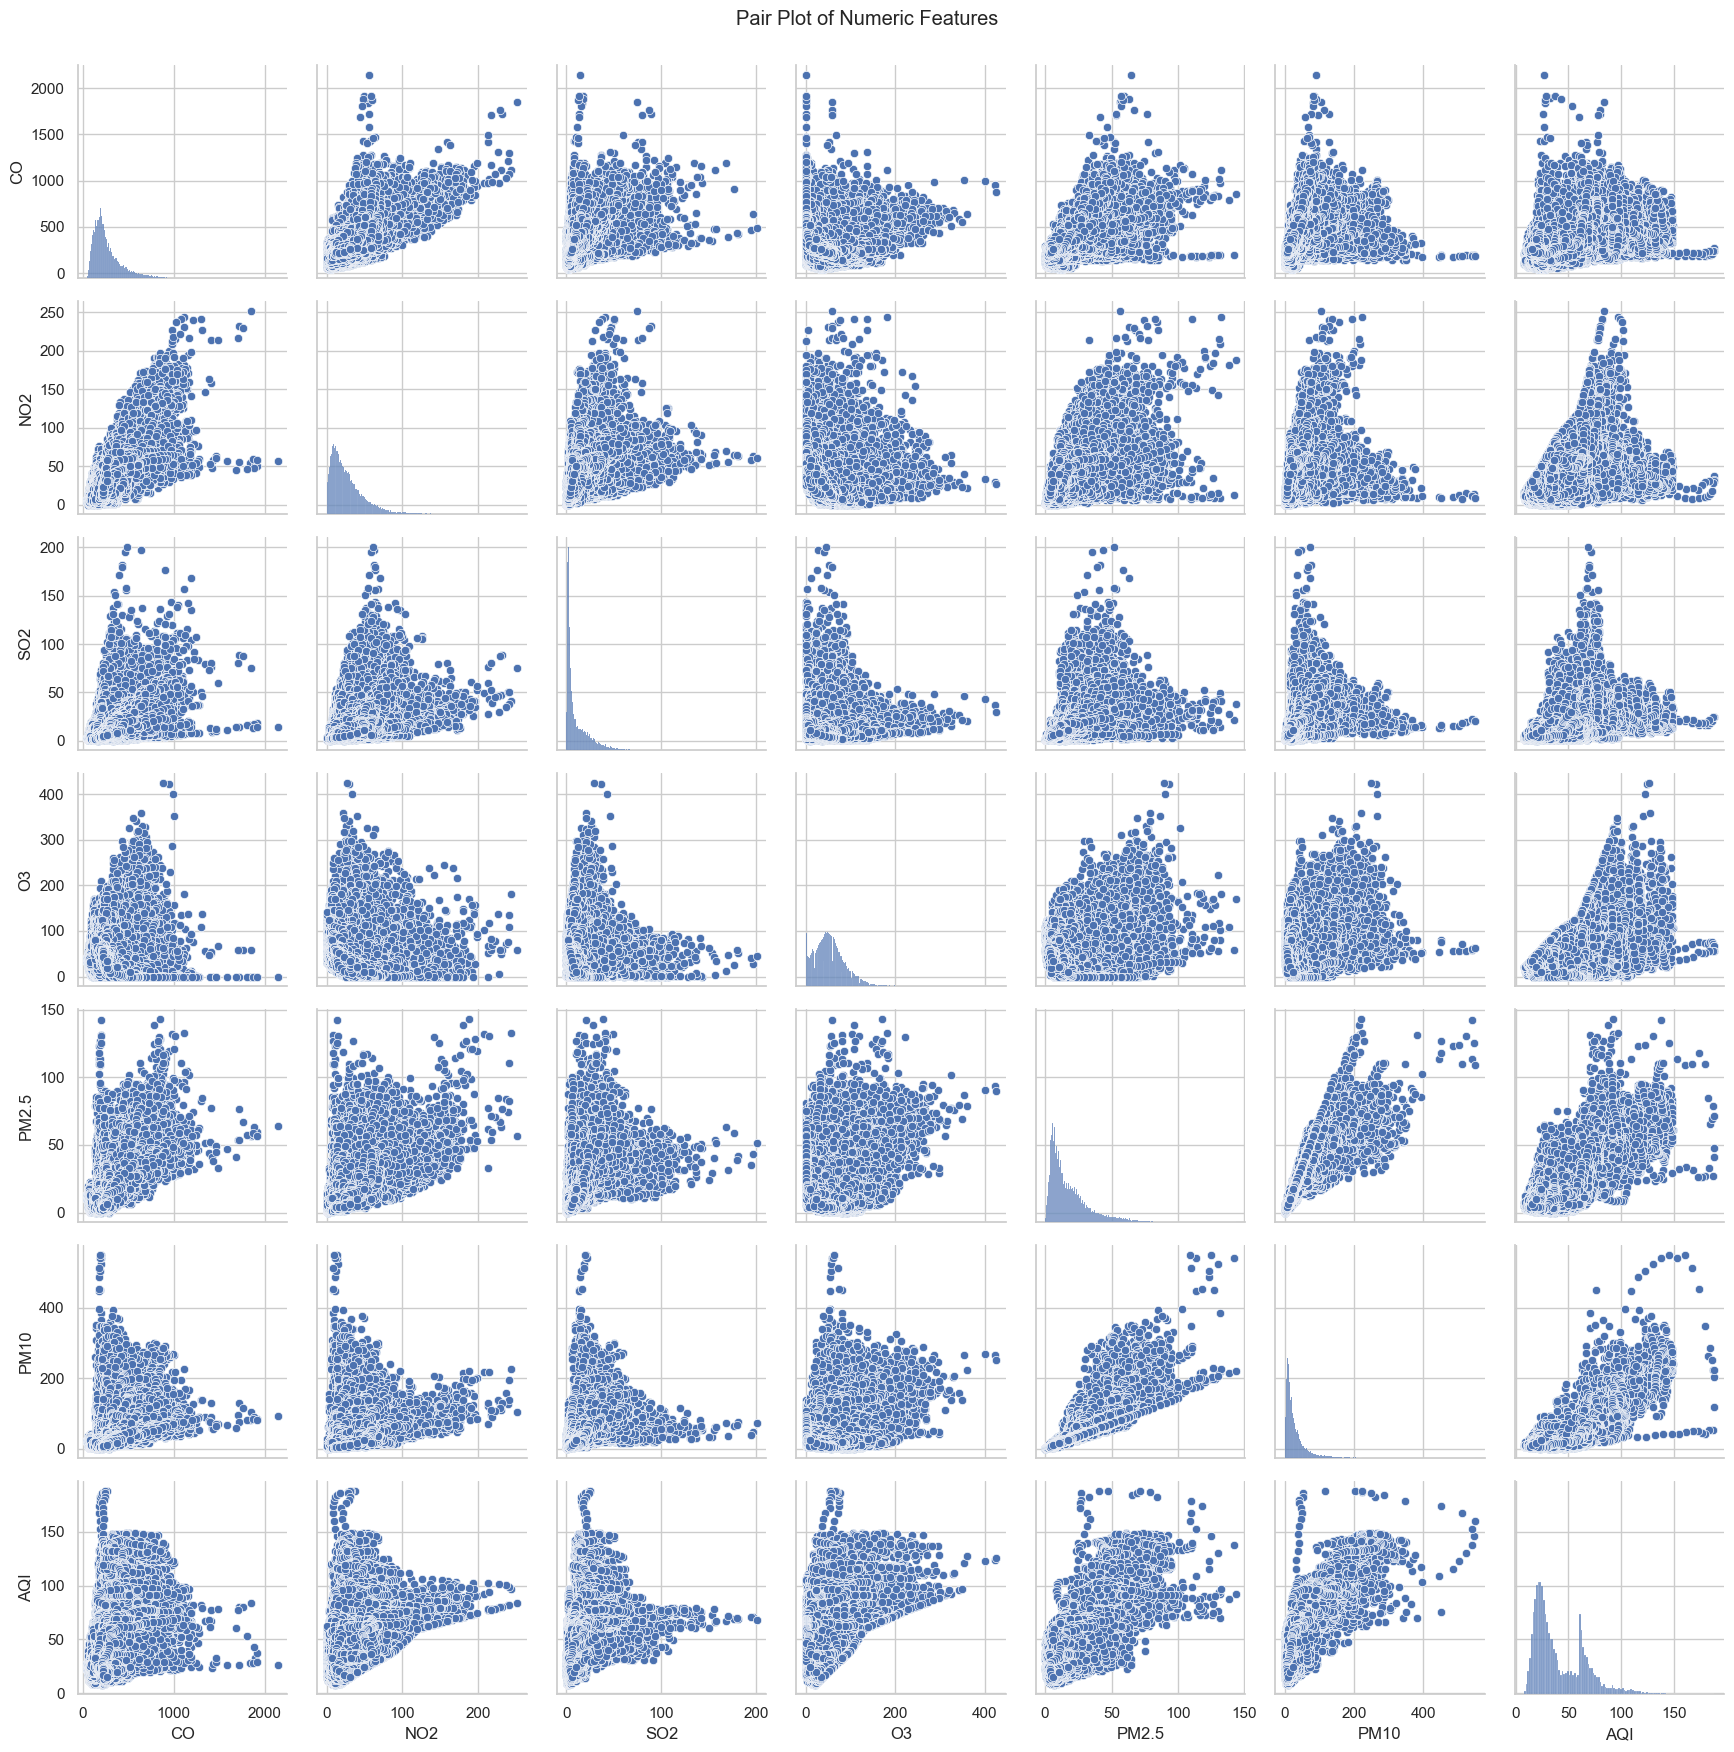

In [16]:
try:
    sns.pairplot(numeric_df) # 数值型数据的成对关系图
    plt.suptitle('Pair Plot of Numeric Features', y=1)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating pair plot: {e}")

# 对角线是单个变量的分布，非对角线是不同变量之前的关系图

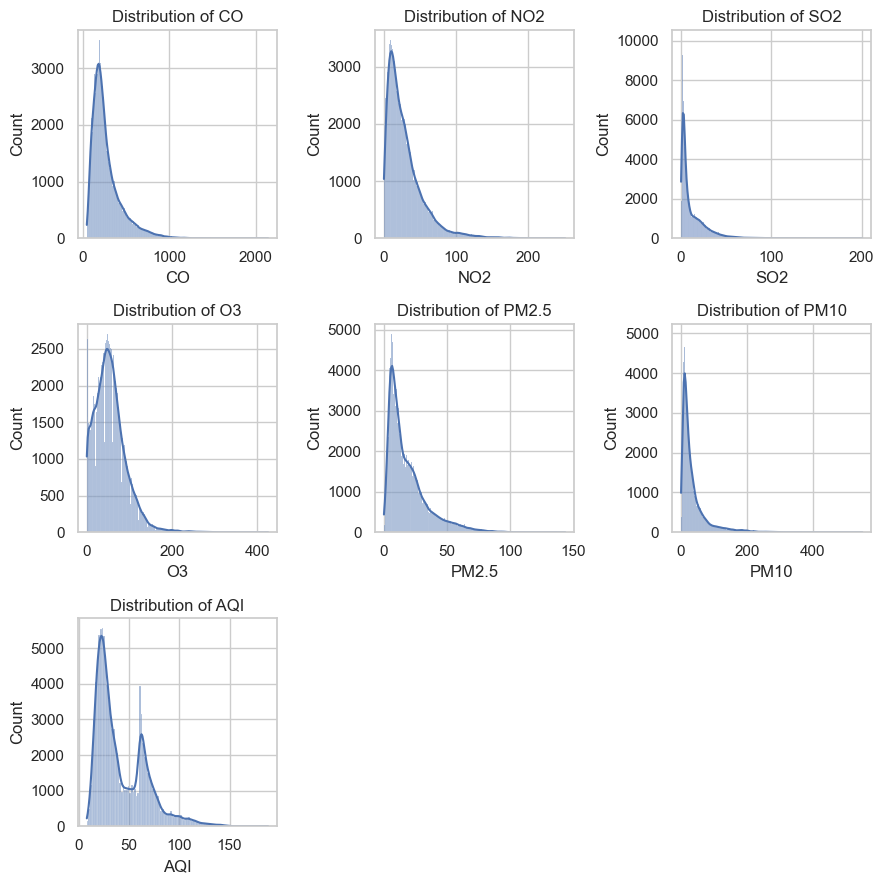

In [21]:
num_l = 3
num_rs = 3
plt.figure(figsize=(num_l * 3, num_rs * 3))

for i, col in enumerate(numeric_df.columns):
    plt.subplot(num_rs, num_l, i + 1)
    sns.histplot(numeric_df[col], kde=True) # 直方图加一个核密度估计曲线 kde=True
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

    
plt.tight_layout()
plt.show()

R^2 score of the linear regression model: 0.7926


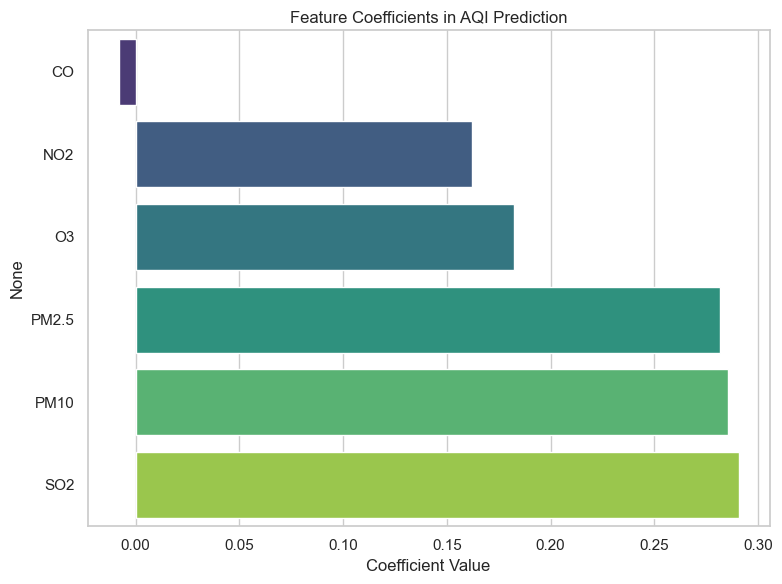

In [22]:
features_cols = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']
target_col = 'AQI'

for col in features_cols:
    if col not in df.columns:
        raise ValueError(f"Feature column '{col}' not found in the dataframe.")
    
X = df[features_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 score of the linear regression model: {r2:.4f}")

coefficients = pd.Series(lr_model.coef_, index=features_cols)
coefficients = coefficients.sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis')
plt.title('Feature Coefficients in AQI Prediction')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()



In [26]:
Sydney_data = df[df['City'] == 'Sydney']

In [27]:
Sydney_data

,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,2023-01-01 00:00:00+00:00,Sydney,62.0,6.00,3.65,41.0,9.2,16.5,23.583336
1,2023-01-01 01:00:00+00:00,Sydney,62.0,5.25,3.45,45.0,9.1,16.5,23.466667
2,2023-01-01 02:00:00+00:00,Sydney,61.0,4.15,3.20,50.0,8.8,15.9,23.325003
3,2023-01-01 03:00:00+00:00,Sydney,61.0,3.20,2.90,55.0,8.8,16.1,23.150002
4,2023-01-01 04:00:00+00:00,Sydney,62.0,3.15,2.80,54.0,8.7,16.0,22.958332
...,...,...,...,...,...,...,...,...,...
87595,2023-12-31 19:00:00+00:00,Sydney,74.0,8.30,3.50,25.0,11.0,20.0,25.341667
87596,2023-12-31 20:00:00+00:00,Sydney,75.0,8.20,3.90,25.0,12.0,21.9,25.200003
87597,2023-12-31 21:00:00+00:00,Sydney,76.0,7.90,4.20,26.0,14.5,26.7,25.133339
87598,2023-12-31 22:00:00+00:00,Sydney,77.0,7.40,4.40,28.0,13.5,24.7,25.116669


In [29]:
Sydney_data['Date'] = pd.to_datetime(Sydney_data['Date'])

# 按日期排序
Sydney_data = Sydney_data.sort_values('Date').reset_index(drop=True)

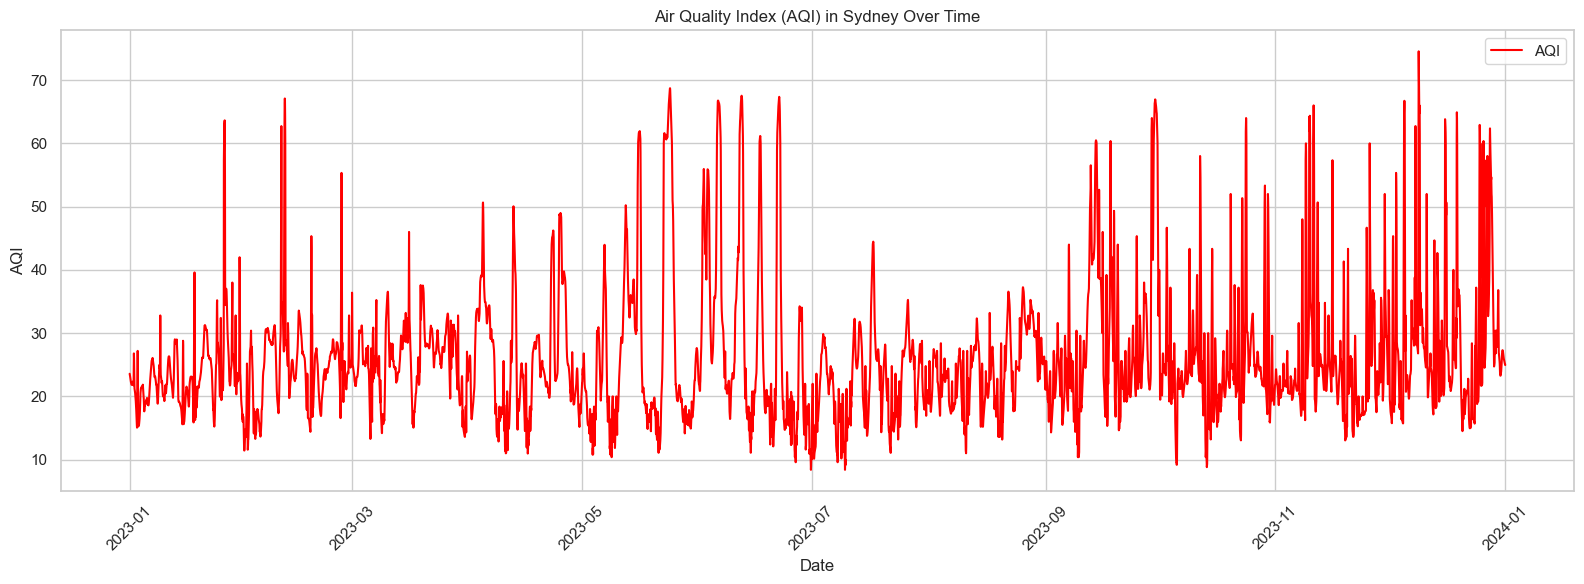

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(Sydney_data['Date'], Sydney_data['AQI'], label='AQI', color='red')
plt.title('Air Quality Index (AQI) in Sydney Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [31]:
Sydney_data['Date'] = pd.to_datetime(Sydney_data['Date'])
Sydney_data.sort_values('Date', inplace=True)

In [33]:
Sydney_feature = Sydney_data[features_cols]
Sydney_target = Sydney_data[target_col]

In [34]:
SEQ_LEN = 24
X, y = [], []
for i in range(len(Sydney_feature) - SEQ_LEN):
    X.append(Sydney_feature.iloc[i:i + SEQ_LEN].values)
    y.append(Sydney_target.iloc[i + SEQ_LEN])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)



In [35]:


# 划分训练测试
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# CNN-LSTM 框架

Inception-style 多尺度模块

In [ ]:
import torch
from torch import nn

class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, feature_dim):
        """
        并行多尺度卷积块
        :param in_channels: 输入通道数（通常是1）
        :param out_channels: 输出通道数
        :param feature_dim: 特征数量 
        """
        super().__init__()

        self.branch1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1,1), padding=(0,0)
        )

        self.branch2 = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1,3), padding=(0,1)
        )

        self.branch3 = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1,5), padding=(0,2)
        )

        self.branch4 = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1,7), padding=(0,3)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)

        out = torch.cat([x1, x2, x3, x4], dim=1)

        return self.relu(out)



LSTM 改进模块 -- 双向（BiLSTM）、多层LSTM+残差连接、Transformer Encoder

In [ ]:
# CNN + BiLSTM 模型
class CNN_BiLSTM(nn.Module):
    def __init__(self, feature_dim=6, seq_len=24, hidden_dim=64):
        super().__init__()
        self.feature_dim = feature_dim
        self.seq_len = seq_len
        
        # 多尺度卷积：4 branches × 8 channels = 32
        self.multi_conv = MultiScaleConvBlock(in_channels=1, out_channels_per_branch=8, feature_dim=feature_dim)
        
        # BiLSTM：输出维度翻倍 → 64 * 2 = 128
        self.lstm = nn.LSTM(
            input_size=32 * feature_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)  # 双向 → ×2

    def forward(self, x):
        """
        x: (B, T, F, C) = (batch, seq_len, feature_dim, 1)
        """
        B, T, F, C = x.shape
        assert F == self.feature_dim and T == self.seq_len, f"Expected ({self.seq_len}, {self.feature_dim}), got ({T}, {F})"
        
        # Reshape for Conv2d: (B*T, C, 1, F)
        x = x.view(B * T, C, 1, F)
        x = self.multi_conv(x)          # (B*T, 32, 1, F)
        x = x.squeeze(2)                # (B*T, 32, F)
        x = x.view(B, T, -1)            # (B, T, 32*F)

        # BiLSTM
        output, (h_n, _) = self.lstm(x)  # h_n: (2, B, hidden_dim)
        h_last = torch.cat([h_n[-2], h_n[-1]], dim=-1)  # (B, 128)
        out = self.fc(h_last)           # (B, 1)
        return out.squeeze(-1)          # (B,)

In [39]:
# 堆叠残差LSTM模块
class StackedResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2): # input_size是第一层LSTM的输入特征维度，hidden_size是LSTM隐藏层维度，num_layers是堆叠的LSTM层数
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList() # 是一个容器，用于储存多个子模块，layers 存放所有的LSTM层
        self.projections = nn.ModuleList() # 存放用于残差连接的投影层

        for i in range(num_layers):
            inp = input_size if i == 0 else hidden_size
            self.layers.append(nn.LSTM(inp, hidden_size, batch_first=True)) # 表示输入形状为 （B，T，D）
            # 用于残差连接的投影（仅当维度不匹配时）
            if i == 0 and input_size != hidden_size:
                self.projections.append(nn.Linear(input_size, hidden_size))
            else:
                self.projections.append(None)

    def forward(self, x):
        residual = x
        for i in range(self.num_layers):
            x, _ = self.layers[i](x)
            if i == 0 and self.projections[i] is not None:
                residual = self.projections[i](residual)
            if i > 0:
                x = x + residual
                residual = x
        return x


class CNN_ResidualLSTM(nn.Module):
    def __init__(self, feature_dim=6, seq_len=24, hidden_dim=64, num_lstm_layers=2):
        super().__init__()
        self.feature_dim = feature_dim
        self.seq_len = seq_len
        
        self.multi_conv = MultiScaleConvBlock(in_channels=1, out_channels=8, feature_dim=feature_dim)
        self.lstm_stack = StackedResidualLSTM(
            input_size=32 * feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_lstm_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        B, T, F, C = x.shape
        assert F == self.feature_dim and T == self.seq_len
        
        x = x.view(B * T, C, 1, F)
        x = self.multi_conv(x)
        x = x.squeeze(2)
        x = x.view(B, T, -1)  # (B, T, 32*F)

        x = self.lstm_stack(x)           # (B, T, hidden_dim)
        out = self.fc(x[:, -1, :])       # (B, 1)
        return out.squeeze(-1)           # (B,)

In [ ]:
# Transformer Encoder 部分
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]


class CNN_Transformer(nn.Module):
    def __init__(self, feature_dim=6, seq_len=24, d_model=None, nhead=8, num_layers=2):
        super().__init__()
        self.feature_dim = feature_dim
        self.seq_len = seq_len
        
        # 确保 d_model 能被 nhead 整除，且 ≥ feature 维度
        if d_model is None:
            d_model = 32 * feature_dim  # 来自 CNN 输出
        assert d_model % nhead == 0, f"d_model ({d_model}) must be divisible by nhead ({nhead})"
        self.d_model = d_model

        self.multi_conv = MultiScaleConvBlock(in_channels=1, out_channels_per_branch=8, feature_dim=feature_dim)
        
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        B, T, F, C = x.shape
        assert F == self.feature_dim and T == self.seq_len
        
        x = x.view(B * T, C, 1, F)
        x = self.multi_conv(x)
        x = x.squeeze(2)
        x = x.view(B, T, -1)  # (B, T, d_model)

        x = self.pos_encoder(x)
        x = self.transformer(x)           # (B, T, d_model)
        out = self.fc(x[:, -1, :])        # (B, 1)
        return out.squeeze(-1)            # (B,)

原来的CNNLSTM模块

In [1]:
import torch
from torch import nn

class CNNLSTM(nn.Module):
    def __init__(self, in_channels=1, feature_dim=6, seq_len=24, hidden_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(32 * feature_dim, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        B, T, F, C = x.shape
        x = x.view(B * T, C, 1, F)
        x = self.conv(x).squeeze(2)  # (B*T, 通道, 特征)
        x = x.view(B, T, -1)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.squeeze()



In [40]:
model = CNN_ResidualLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()        

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze()

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = loss_fn(preds, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 91.8449
Epoch 20, Loss: 94.3907
Epoch 30, Loss: 73.4155
Epoch 40, Loss: 65.0483
Epoch 50, Loss: 62.2050
Epoch 60, Loss: 58.9005
Epoch 70, Loss: 55.6674
Epoch 80, Loss: 53.6434
Epoch 90, Loss: 52.2476
Epoch 100, Loss: 50.9326
Epoch 110, Loss: 49.7184
Epoch 120, Loss: 48.9237
Epoch 130, Loss: 48.8988
Epoch 140, Loss: 47.8695
Epoch 150, Loss: 46.0451
Epoch 160, Loss: 44.8055
Epoch 170, Loss: 43.9034
Epoch 180, Loss: 42.7833
Epoch 190, Loss: 42.5524
Epoch 200, Loss: 41.2596
Epoch 210, Loss: 40.5322
Epoch 220, Loss: 39.8601
Epoch 230, Loss: 39.1292
Epoch 240, Loss: 39.9226
Epoch 250, Loss: 38.3366
Epoch 260, Loss: 37.4756
Epoch 270, Loss: 36.6824
Epoch 280, Loss: 39.3871
Epoch 290, Loss: 36.9765
Epoch 300, Loss: 35.5755
Epoch 310, Loss: 34.9621
Epoch 320, Loss: 34.4402
Epoch 330, Loss: 34.0822
Epoch 340, Loss: 33.8253
Epoch 350, Loss: 33.3028
Epoch 360, Loss: 33.6257
Epoch 370, Loss: 32.5043
Epoch 380, Loss: 31.7661
Epoch 390, Loss: 31.4614
Epoch 400, Loss: 31.5490
Epoch 410

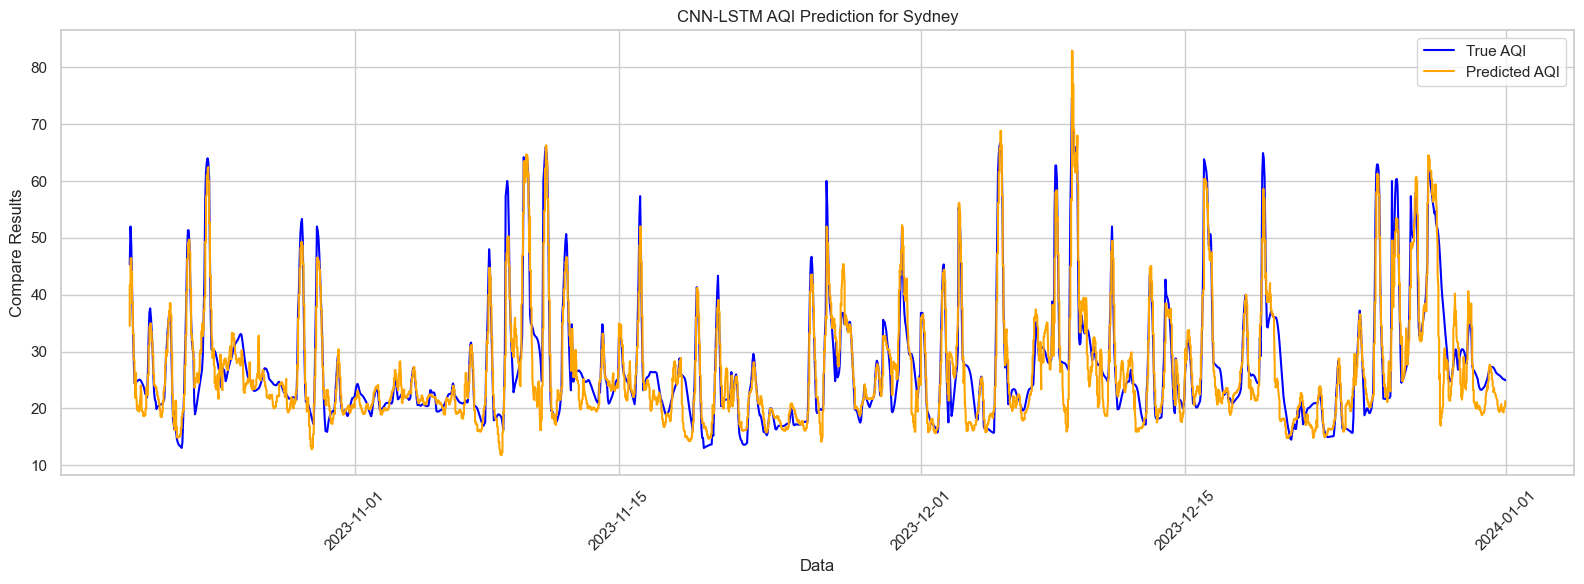

In [64]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze()
preds = model(X_test_tensor)
preds = preds.detach().numpy()

plt.figure(figsize=(16, 6))
plt.plot(Sydney_data['Date'].iloc[-len(y_test):], y_test, label='True AQI', color='blue')
plt.plot(Sydney_data['Date'].iloc[-len(y_test):], preds, label='Predicted AQI', color='orange')
plt.xlabel('Data')
plt.ylabel('Compare Results')
plt.title('CNN-LSTM AQI Prediction for Sydney')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



指标测试

In [53]:
# MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

train_metrics = {
    'epoch': [],
    'MSE' : [],
    'MAE' : [],
    'RMSE': [],
    'R2'  : [],
    'ACC' : []
}
val_metrics = {
  'epoch': [],
  'MSE' : [],
  'MAE' : [],
  'RMSE' : [],
  'R2' : [],
  'ACC' : []
 }

def aqi_to_level(aqi):
    if aqi <= 50:
        return 0  # 优
    elif aqi <= 100:
        return 1  # 良
    elif aqi <= 150:
        return 2  # 轻度污染
    elif aqi <= 200:
        return 3  # 中度污染
    elif aqi <= 300:
        return 4  # 重度污染
    else:
        return 5  # 严重污染
    
best_val_mae = float('inf')
patience = 50
trigger_times = 0
best_epoch = 0

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze()
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze()

model = CNN_ResidualLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(4000):
    model.train()
    optimizer.zero_grad()

    train_preds = model(X_train_tensor)
    train_loss = loss_fn(train_preds, y_train_tensor)

    train_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_preds_np = train_preds.detach().cpu().numpy()
            y_train_np = y_train_tensor.detach().cpu().numpy()

            mse = mean_squared_error(y_train_np, train_preds_np)
            mae = mean_absolute_error(y_train_np, train_preds_np)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_train_np, train_preds_np)

            true_levels = np.array([aqi_to_level(aqi) for aqi in y_train_np])
            pred_levels = np.array([aqi_to_level(aqi) for aqi in train_preds_np])
            acc = np.mean(true_levels == pred_levels)

        with torch.no_grad():
            val_preds = model(X_test_tensor).detach().cpu().numpy()
            y_val_np = y_test_tensor.detach().cpu().numpy()

            val_mse = mean_squared_error(y_val_np, val_preds)
            val_mae = mean_absolute_error(y_val_np, val_preds)
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(y_val_np, val_preds)

            val_true_levels = np.array([aqi_to_level(aqi) for aqi in y_val_np])
            val_pred_levels = np.array([aqi_to_level(aqi) for aqi in val_preds])
            val_acc = np.mean(val_true_levels == val_pred_levels)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), 'best_model.pth')  # 保存最佳模型
            print(f"🏆 New best model saved at epoch {epoch+1}! Val MAE: {val_mae:.2f}")

        train_metrics['epoch'].append(epoch + 1)
        train_metrics['MSE'].append(mse)
        train_metrics['MAE'].append(mae)
        train_metrics['RMSE'].append(rmse)
        train_metrics['R2'].append(r2)
        train_metrics['ACC'].append(acc)

        val_metrics['epoch'].append(epoch + 1)
        val_metrics['MSE'].append(val_mse)
        val_metrics['MAE'].append(val_mae)
        val_metrics['RMSE'].append(val_rmse)
        val_metrics['R2'].append(val_r2)
        val_metrics['ACC'].append(val_acc)

        print(f"Epoch {epoch+1:4d} | "
              f"Train: MSE={mse:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, ACC={acc:.3f} | "
              f"Val: MSE={val_mse:.2f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}, ACC={val_acc:.3f}")
        
        model.train()

print("训练完成！指标已经保存在train_metrics和val_metrics字典中")

🏆 New best model saved at epoch 10! Val MAE: 4.39
Epoch   10 | Train: MSE=184.56, MAE=8.98, RMSE=13.59, R²=-0.786, ACC=0.932 | Val: MSE=31.33, MAE=4.39, RMSE=5.60, R²=0.728, ACC=0.964
🏆 New best model saved at epoch 20! Val MAE: 4.08
Epoch   20 | Train: MSE=102.34, MAE=6.74, RMSE=10.12, R²=0.010, ACC=0.962 | Val: MSE=27.46, MAE=4.08, RMSE=5.24, R²=0.761, ACC=0.980
Epoch   30 | Train: MSE=83.04, MAE=6.89, RMSE=9.11, R²=0.196, ACC=0.955 | Val: MSE=48.14, MAE=5.80, RMSE=6.94, R²=0.582, ACC=0.960
🏆 New best model saved at epoch 40! Val MAE: 3.94
Epoch   40 | Train: MSE=69.96, MAE=5.60, RMSE=8.36, R²=0.323, ACC=0.961 | Val: MSE=25.40, MAE=3.94, RMSE=5.04, R²=0.779, ACC=0.975
🏆 New best model saved at epoch 50! Val MAE: 3.76
Epoch   50 | Train: MSE=65.25, MAE=5.49, RMSE=8.08, R²=0.369, ACC=0.960 | Val: MSE=24.83, MAE=3.76, RMSE=4.98, R²=0.784, ACC=0.968
Epoch   60 | Train: MSE=62.79, MAE=5.47, RMSE=7.92, R²=0.392, ACC=0.960 | Val: MSE=25.93, MAE=3.96, RMSE=5.09, R²=0.775, ACC=0.972
Epoch   7

可视化

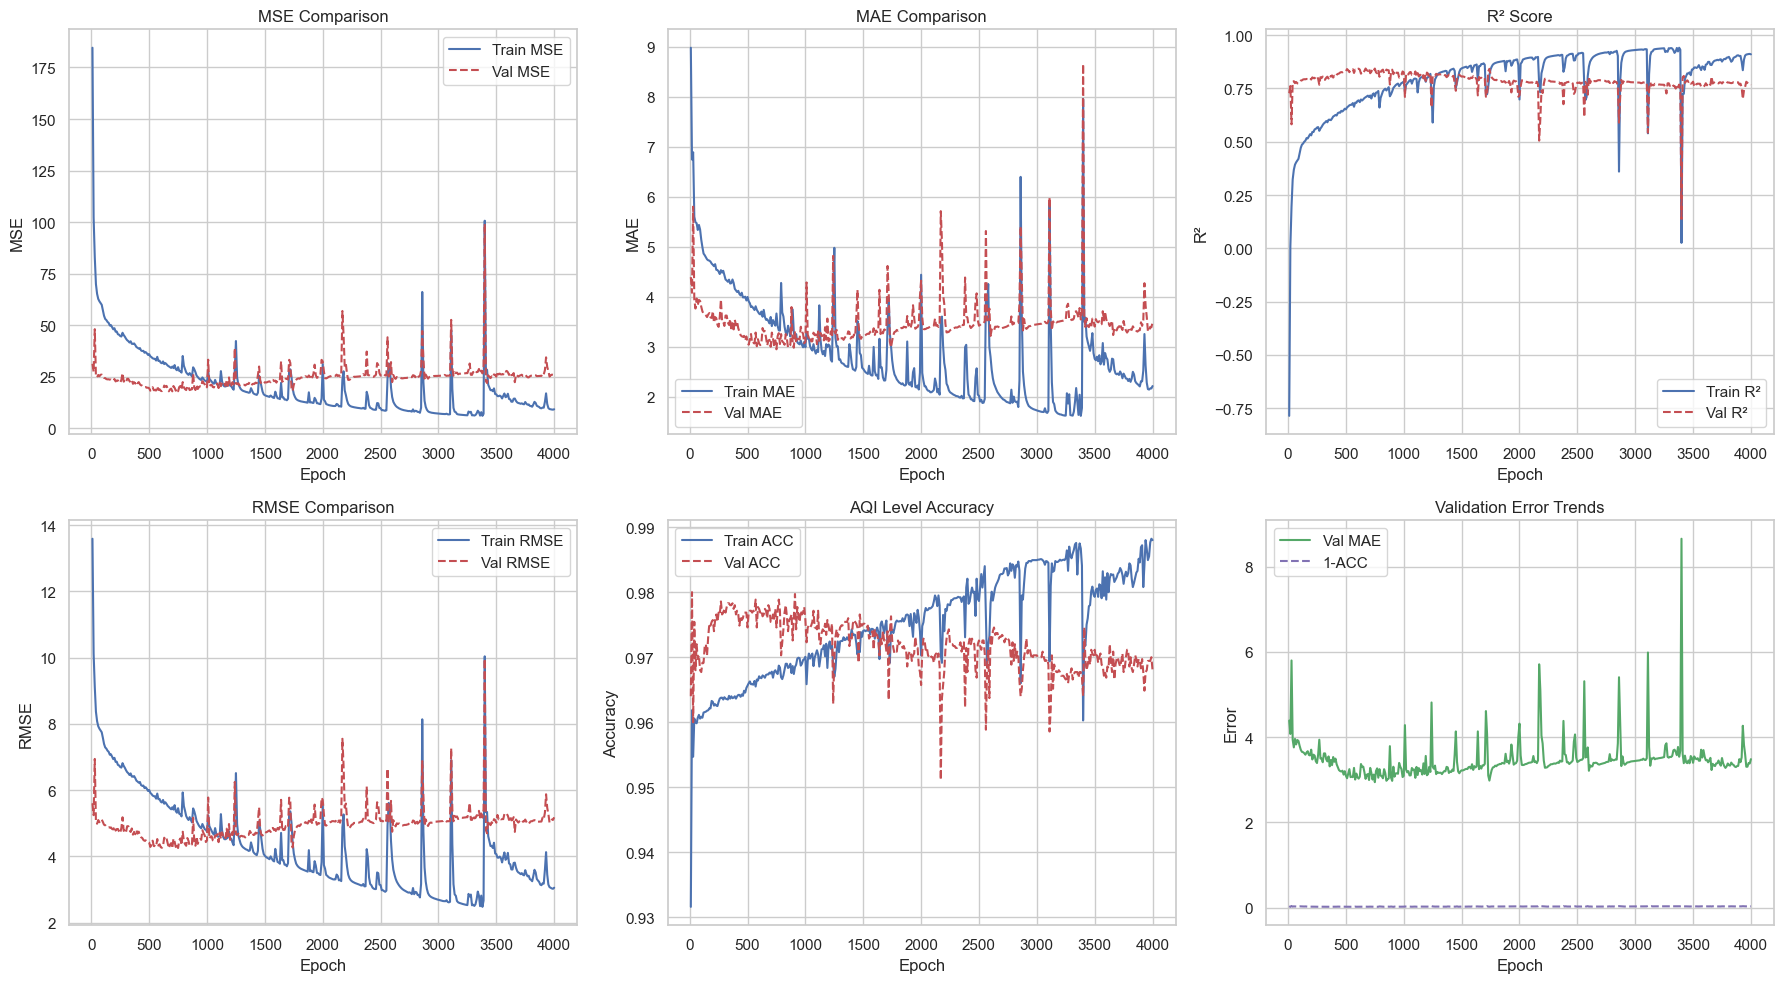

In [55]:
import matplotlib.pyplot as plt

# 创建2行3列的指标对比图
plt.figure(figsize=(18, 10))

# 1. MSE
plt.subplot(2, 3, 1)
plt.plot(train_metrics['epoch'], train_metrics['MSE'], 'b-', label='Train MSE')
plt.plot(val_metrics['epoch'], val_metrics['MSE'], 'r--', label='Val MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('MSE Comparison')

# 2. MAE
plt.subplot(2, 3, 2)
plt.plot(train_metrics['epoch'], train_metrics['MAE'], 'b-', label='Train MAE')
plt.plot(val_metrics['epoch'], val_metrics['MAE'], 'r--', label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE Comparison')

# 3. R²
plt.subplot(2, 3, 3)
plt.plot(train_metrics['epoch'], train_metrics['R2'], 'b-', label='Train R²')
plt.plot(val_metrics['epoch'], val_metrics['R2'], 'r--', label='Val R²')
plt.xlabel('Epoch'); plt.ylabel('R²'); plt.legend(); plt.title('R² Score')

# 4. RMSE
plt.subplot(2, 3, 4)
plt.plot(train_metrics['epoch'], train_metrics['RMSE'], 'b-', label='Train RMSE')
plt.plot(val_metrics['epoch'], val_metrics['RMSE'], 'r--', label='Val RMSE')
plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.title('RMSE Comparison')

# 5. ACC (等级准确率)
plt.subplot(2, 3, 5)
plt.plot(train_metrics['epoch'], train_metrics['ACC'], 'b-', label='Train ACC')
plt.plot(val_metrics['epoch'], val_metrics['ACC'], 'r--', label='Val ACC')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('AQI Level Accuracy')

# 6. 验证集指标趋势（关键！）
plt.subplot(2, 3, 6)
plt.plot(val_metrics['epoch'], val_metrics['MAE'], 'g-', label='Val MAE')
plt.plot(val_metrics['epoch'], [1-x for x in val_metrics['ACC']], 'm--', label='1-ACC')  # 误差率
plt.xlabel('Epoch'); plt.ylabel('Error'); plt.legend(); plt.title('Validation Error Trends')

plt.tight_layout()
plt.savefig('training_metrics.jpg', dpi=300)
plt.show()

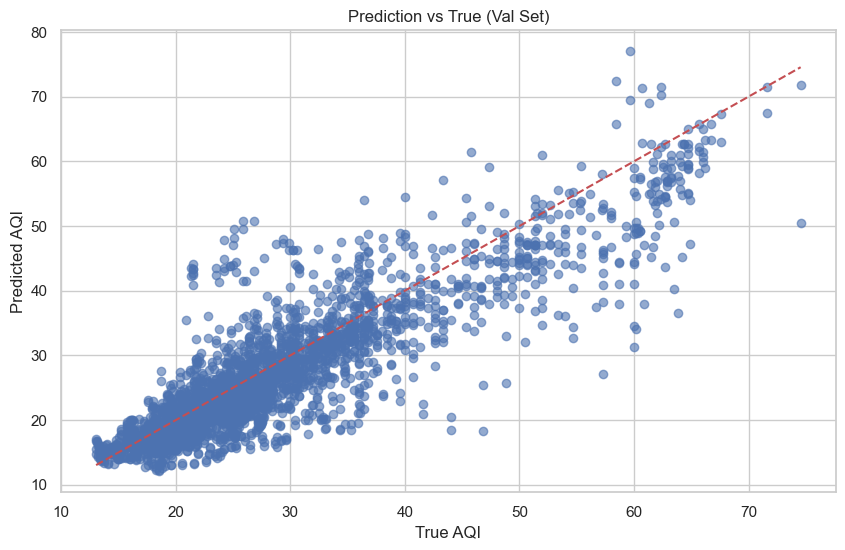

In [56]:
plt.scatter(y_val_np, val_preds, alpha=0.6)
plt.plot([y_val_np.min(), y_val_np.max()], [y_val_np.min(), y_val_np.max()], 'r--')
plt.xlabel('True AQI'); plt.ylabel('Predicted AQI')
plt.title('Prediction vs True (Val Set)')
plt.show()

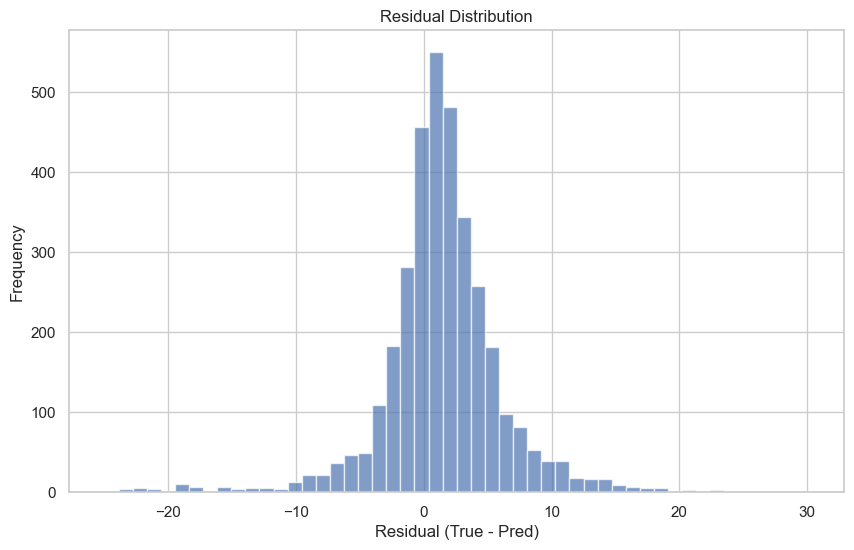

In [57]:
residuals = y_val_np - val_preds
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residual (True - Pred)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

使用训练好的模型，测试其他地方

Brasilia城市

In [60]:
Brasilia_data = df[df['City'] == 'Brasilia']
Brasilia_data['Date'] = pd.to_datetime(Brasilia_data['Date'])
Brasilia_data = Brasilia_data.sort_values('Date').reset_index(drop=True)

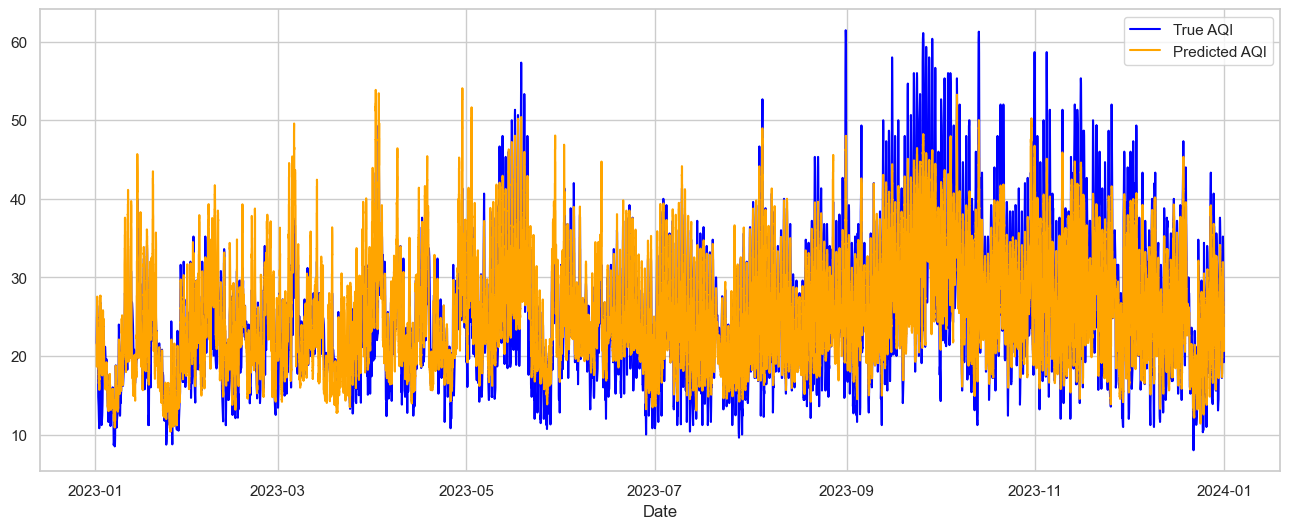

Brasilia AQI Prediction - MSE: 16.76, MAE: 3.04, RMSE: 4.09, R²: 0.799, ACC: 0.983


In [63]:
Brasilia_feature = Brasilia_data[features_cols]
Brasilia_target = Brasilia_data[target_col]
SEQ_LEN = 24
X_bra, y_bra = [], []
for i in range(len(Brasilia_feature) - SEQ_LEN):
    X_bra.append(Brasilia_feature.iloc[i:i + SEQ_LEN].values)
    y_bra.append(Brasilia_target.iloc[i + SEQ_LEN])
X_bra = np.array(X_bra)
y_bra = np.array(y_bra)
X_bra = X_bra.reshape(X_bra.shape[0], X_bra.shape[1], X_bra.shape[2], 1)
X_bra_tensor = torch.tensor(X_bra, dtype=torch.float32)
model = CNN_ResidualLSTM()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    bra_preds = model(X_bra_tensor).detach().cpu().numpy()
plt.figure(figsize=(16, 6))
plt.plot(Brasilia_data['Date'].iloc[-len(y_bra):], y_bra, label='True AQI', color='blue')
plt.plot(Brasilia_data['Date'].iloc[-len(y_bra):], bra_preds, label='Predicted AQI', color='orange')
plt.xlabel('Date')
plt.legend()
plt.show()

# 指标
mse_bra = mean_squared_error(y_bra, bra_preds)
mae_bra = mean_absolute_error(y_bra, bra_preds)
rmse_bra = np.sqrt(mse_bra)
r2_bra = r2_score(y_bra, bra_preds)
true_levels_bra = np.array([aqi_to_level(aqi) for aqi in y_bra])
pred_levels_bra = np.array([aqi_to_level(aqi) for aqi in bra_preds])
acc_bra = np.mean(true_levels_bra == pred_levels_bra)
print(f"Brasilia AQI Prediction - MSE: {mse_bra:.2f}, MAE: {mae_bra:.2f}, RMSE: {rmse_bra:.2f}, R²: {r2_bra:.3f}, ACC: {acc_bra:.3f}")

In [42]:
London_data = df[df['City'] == 'London']
London_feature = London_data[features_cols]
London_target = London_data[target_col]
London_data['Date'] = pd.to_datetime(London_data['Date'])
London_data.sort_values('Date', inplace=True)

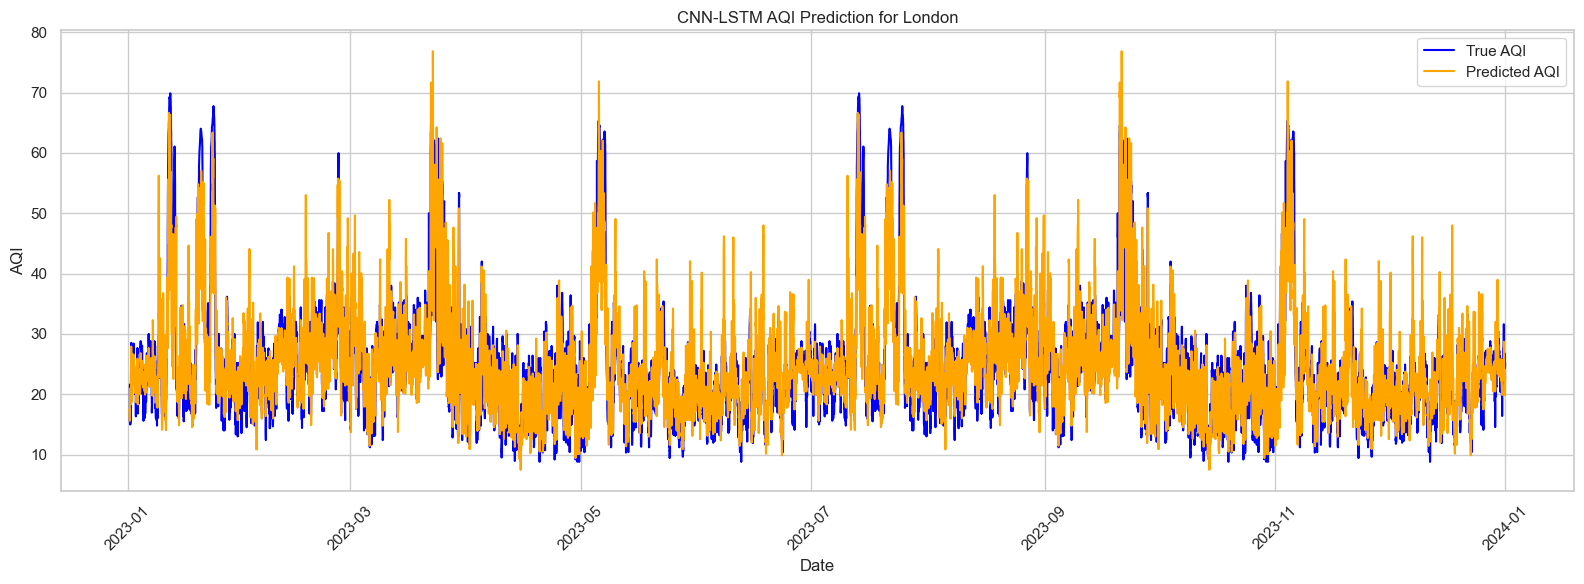

In [58]:
X_ld, y_ld = [], []
for i in range(len(London_feature) - SEQ_LEN):
    X_ld.append(London_feature.iloc[i:i + SEQ_LEN].values)
    y_ld.append(London_target.iloc[i + SEQ_LEN])

X_ld = np.array(X_ld)
y_ld = np.array(y_ld)

X_ld = X_ld.reshape(X_ld.shape[0], X_ld.shape[1], X_ld.shape[2], 1)

model.eval()
London_feature_tensor = torch.tensor(X_ld, dtype=torch.float32)
London_preds = model(London_feature_tensor).detach().numpy()

date_slice = London_data['Date'].iloc[SEQ_LEN:].values

plt.figure(figsize=(16, 6))
plt.plot(date_slice, y_ld, label='True AQI', color='blue')
plt.plot(date_slice, London_preds, label='Predicted AQI', color='orange')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('CNN-LSTM AQI Prediction for London')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


进一步应用

CNN+ResiaualLSTM 模型是一种多变量预测模型 
+ 进一步可以尝试多步预测（1h，6h，12h，24h）
+ 多指标
  
不是单变量预测模型 （N-BEATS、TCN（Temporal Convolutional Network 时域卷积网络））